# PyMCでのIRTモデルの実装例

既製品の標準的なモデル（2PLMなど）はパッケージで最尤推定すれば十分だが、Pythonの場合はIRT用のパッケージ（例えば [pyirt](https://github.com/17zuoye/pyirt)）が数年前に更新が止まっている。

複雑な、独自のモデルはベイズモデリングする必要があり、PyMCやPyStanなどが候補になる。


## 2PLM

#### データの生成

In [106]:
# ダミーデータの生成
# 参考： https://qiita.com/takuyakubo/items/43d56725952e67032b49
import numpy as np
import pandas as pd
from functools import partial
np.random.seed(0)

# 2 parameter logistic model の定義
def ICC2PLM(a, b, theta):
    return 1 / (1 + np.exp(-  a * (theta - b)))

# model parameterの定義
a_min = 0.5
a_max = 3.0

b_min = -2.0
b_max = 2.0

# 問題数と回答者数
num_items = 15
num_users = 1000

# 問題parameterの生成
item_params = np.array(
    [np.random.uniform(a_min, a_max, num_items),
     np.random.uniform(b_min, b_max, num_items)]
).T
true_params = pd.DataFrame(item_params, 
                           index=[f"question_{j+1}" for j in range(num_items)],
                           columns=["a","b"])

# 受験者parameterの生成
true_thetas = np.random.normal(size=num_users)

# 項目反応行列の作成、 要素は1(正答)か0(誤答)
# i行j列は問iに受験者jがどう反応したか
ir_matrix_ij = np.vectorize(int)(
    np.array([partial(ICC2PLM, *param)(true_thetas) + np.random.uniform(-0.05, 0.05, num_users) > 0.5 for param in item_params])
)

df = pd.DataFrame(ir_matrix_ij.T,
                  index=[f"user_{i+1}" for i in range(num_users)],
                  columns=[f"question_{j+1}" for j in range(num_items)])

df.head()

,question_1,question_2,question_3,question_4,question_5,question_6,question_7,question_8,question_9,question_10,question_11,question_12,question_13,question_14,question_15
user_1,1,1,0,0,0,0,0,1,0,1,1,1,0,1,1
user_2,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0
user_3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
user_4,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0
user_5,1,1,0,0,0,0,0,1,0,1,0,1,0,0,1


<Axes: ylabel='Frequency'>

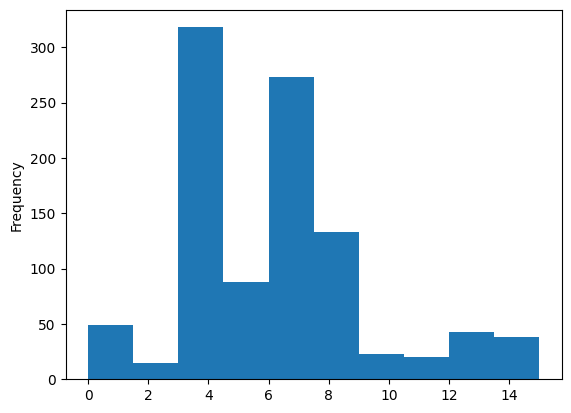

In [107]:
raw_scores = df.sum(axis=1)
raw_scores.plot.hist()

In [108]:
# 縦持ちへ変換
df_long = pd.melt(
    df.reset_index(),
    id_vars="index",
    var_name="item",
    value_name="response",
).rename(columns={"index": "user"})
df_long.head()

,user,item,response
0,user_1,question_1,1
1,user_2,question_1,1
2,user_3,question_1,1
3,user_4,question_1,1
4,user_5,question_1,1


#### モデルの定義

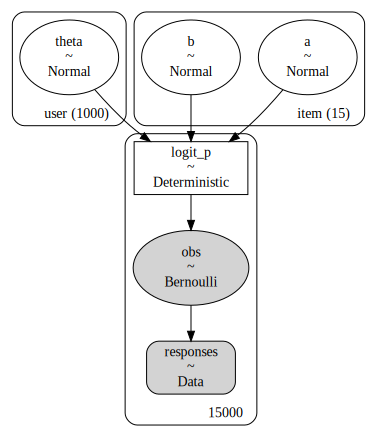

In [117]:
# indexと値の取得
user_idx, users = pd.factorize(df_long["user"])
item_idx, items = pd.factorize(df_long["item"])
responses = df_long["response"].to_numpy()

import pymc as pm
model = pm.Model(coords={"user": df.index, "item": df.columns})
with model:
    # 観測値の配列
    response_obs = pm.Data("responses", responses)

    # 2PLM
    theta = pm.Normal("theta", mu=0.0, sigma=1.0, dims="user")
    a = pm.Normal("a", mu=0.0, sigma=1.0, dims="item")
    b = pm.Normal("b", mu=0.0, sigma=1.0, dims="item")

    # ベルヌーイ分布（pではなくlogit_pの引数に渡すことでシグモイド関数の計算をpymc側にまかせている）
    # logit_p = pm.Deterministic("logit_p", a[item_idx] * (theta[user_idx] - b[item_idx]))
    # obs = pm.Bernoulli("obs", logit_p=logit_p, observed=response_obs)

    z = a[item_idx] * (theta[user_idx] - b[item_idx])
    p = pm.Deterministic("p", pm.math.invlogit(z))
    obs = pm.Bernoulli("obs", p=p, observed=response_obs)

g = pm.model_to_graphviz(model)
g

#### 推定

In [118]:
%%time
with model:
    idata = pm.sample(random_seed=0)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


CPU times: user 6.78 s, sys: 1.52 s, total: 8.3 s
Wall time: 26.3 s


#### MAP推定量

In [111]:
with model:
    map_est = pm.find_MAP()

Output()

In [112]:
true_params[["a"]].assign(a_hat = map_est["a"])

,a,a_hat
question_1,1.872034,0.0
question_2,2.287973,0.0
question_3,2.006908,0.0
question_4,1.862208,0.0
question_5,1.559137,0.0
question_6,2.114735,0.0
question_7,1.593968,0.0
question_8,2.729433,0.0
question_9,2.909157,0.0
question_10,1.458604,0.0


In [113]:
true_params[["b"]].assign(b_hat = map_est["b"])

,b,b_hat
question_1,-1.651483,0.0
question_2,-1.919126,0.0
question_3,1.330479,0.0
question_4,1.112627,0.0
question_5,1.480049,0.0
question_6,1.914473,0.0
question_7,1.196634,0.0
question_8,-0.154083,0.0
question_9,1.122117,0.0
question_10,-1.526902,0.0


#### 事後分布

一部の項目の$a_j, b_j$

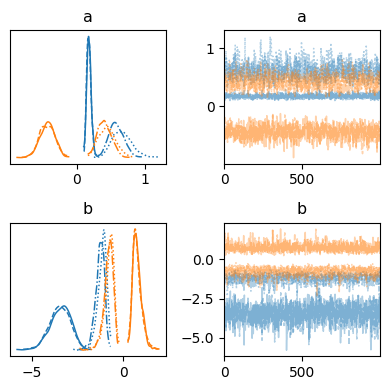

In [11]:
import matplotlib.pyplot as plt
import arviz as az

query = {"item": ["question_1", "question_2"]}

az.plot_trace(idata, coords=query, var_names=["a", "b"], figsize=[4, 4])
plt.tight_layout()
plt.show()

一部の回答者の$\theta_i$

In [ ]:
import matplotlib.pyplot as plt
import arviz as az

query = {"user": ["user_1", "user_2"]}

az.plot_trace(idata, coords=query, var_names=["theta"], figsize=[4, 2])
plt.tight_layout()
plt.show()